In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import numpy as np

loadpath = '/content/drive/MyDrive/nonlinearPCA on cortex/cortex'
expression_train = np.log(np.loadtxt(loadpath + "/data_train", dtype='float32') + 1)
expression_test = np.log(np.loadtxt(loadpath + "/data_test", dtype='float32') + 1)
label_train = np.loadtxt(loadpath + "/label_train")
label_test = np.loadtxt(loadpath + "/label_test")
print(expression_train.shape, expression_test.shape, label_train.shape, label_test.shape)
print("CORTEX dataset: 3005 cells (2253 training, 752 testing), 558 selected highly variable genes.")

(2253, 558) (752, 558) (2253,) (752,)
CORTEX dataset: 3005 cells (2253 training, 752 testing), 558 selected highly variable genes.


In [31]:
import torch
batch_size = 500
train_loader = torch.utils.data.DataLoader(dataset=torch.tensor(expression_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=torch.tensor(expression_test), batch_size=batch_size, shuffle=False)

In [32]:
from torch import nn
from torch import optim

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                nn.ReLU())
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    def forward(self, x):
        xx = self.fc(x)
        qz_m = self.fc_mu(xx)
        qz_logv = self.fc_logvar(xx)
        z = self.reparameterize(qz_m, qz_logv)
        return  z, qz_m, qz_logv

class Decoder_NB(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder_NB, self).__init__()
        self.fc = nn.Sequential(nn.Linear(latent_dim, hidden_dim),
                                nn.ReLU())
        self.mean_nb = nn.Linear(hidden_dim, output_dim)
        self.theta_nb = nn.Linear(hidden_dim, output_dim)
    def forward(self, z, eps=1e-6):
        px = self.fc(z)
        px_m = torch.exp(self.mean_nb(px))
        px_theta = torch.exp(self.theta_nb(px))
        return px_m, px_theta

class IBVAE_scrna_NB(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(IBVAE_scrna_NB, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder_NB(latent_dim, hidden_dim, input_dim)
    def forward(self, x):
        z, qz_m, qz_logv = self.encoder(x)
        px_m, px_theta = self.decoder(z)
        return z, qz_m, qz_logv, px_m, px_theta

In [33]:
from torch.nn import functional
from torch.autograd import Variable, grad
from torch.distributions.negative_binomial import NegativeBinomial

def sigma_estimation(X, Y):
    # sigma from median distance
    D = distmat(torch.cat([X,Y]))
    D = D.detach().cpu().numpy()
    Itri = np.tril_indices(D.shape[0], -1)
    Tri = D[Itri]
    med = np.median(Tri)
    if med <= 0:
        med=np.mean(Tri)
    if med<1E-2:
        med=1E-2
    return med

def distmat(X):
    # distance matrix
    r = torch.sum(X*X, 1)
    r = r.view([-1, 1])
    a = torch.mm(X, torch.transpose(X,0,1))
    D = r.expand_as(a) - 2*a + torch.transpose(r,0,1).expand_as(a)
    D = torch.abs(D)
    return D

def kernelmat(X, sigma):
    # kernel matrix baker
    m = int(X.size()[0])
    dim = int(X.size()[1]) * 1.0
    H = torch.eye(m) - (1./m) * torch.ones([m,m])
    Dxx = distmat(X)
    if sigma:
        variance = 2.*sigma*sigma*X.size()[1]            
        Kx = torch.exp( -Dxx / variance).type(torch.FloatTensor)   # kernel matrices        
        # print(sigma, torch.mean(Kx), torch.max(Kx), torch.min(Kx))
    else:
        try:
            sx = sigma_estimation(X,X)
            Kx = torch.exp( -Dxx / (2.*sx*sx)).type(torch.FloatTensor)
        except RuntimeError as e:
            raise RuntimeError("Unstable sigma {} with maximum/minimum input ({},{})".format(
                sx, torch.max(X), torch.min(X)))
    Kxc = torch.mm(Kx,H)
    return Kxc

def sample_decode_NB(px_m, px_theta, eps=1e-6):
    # sample reconstructed X from NB distribution
    r = px_theta
    p = px_m / (px_m + px_theta + eps)
    nb = NegativeBinomial(r, p)
    return nb.sample()

def HSIC_BI(X, encode, decode, hpara):
    # HSIC
    n = int(X.size()[0])
    X = X.view(n, -1)
    decode = decode.view(n, -1)
    Xxc = kernelmat(X, False)
    Zxc = kernelmat(encode, False)
    Yxc = kernelmat(decode, False)
    BI_value = 1.0/(n-1)**2 * torch.mm(Zxc, Xxc).trace() - hpara * 1.0/(n-1)**2 * torch.mm(Zxc, Yxc).trace()
    return BI_value

def IB_scrna_nb_loss_function(X, qz_m, qz_logv, px_m, px_theta, bpara, hpara, eps=1e-6):
    reconst_loss = -(torch.lgamma(X+px_theta) - torch.lgamma(px_theta) - torch.lgamma(X+1)
                    + px_theta * (torch.log(px_theta+eps) - torch.log(px_theta+px_m+eps))
                    + X * (torch.log(px_m+eps) - torch.log(px_theta+px_m+eps))).sum()
    KLD = -0.5 * torch.sum(1 + qz_logv - qz_m.pow(2) - qz_logv.exp())
    decode = sample_decode_NB(px_m, px_theta)
    IB_loss = HSIC_BI(X, qz_m, decode, hpara)
    return reconst_loss + KLD + bpara * IB_loss

In [34]:
import time
from tqdm import tqdm

def fit_model(X_train, X_test, batch_size=500, latent_dim=10, hidden_dim=128, 
              hpara=100, bpara=1e5, num_epochs=100, learning_rate=1e-3, pretrain=False):
    p = X_train.shape[1]
    train_loader = torch.utils.data.DataLoader(dataset=torch.tensor(X_train), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=torch.tensor(X_test), batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if pretrain is True:
        model = torch.load('IBVAE_CORTEX_pretrain.pth').to(device)
        result = {'epochs': [], 'train_losses': [], 'test_losses': [], 'times': []}
    else:
        model = IBVAE_scrna_NB(p, hidden_dim, latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
        epochs = []
        train_losses = []
        test_losses = []
        times = []
        # train model
        for epoch in range(num_epochs):
            start = time.time()
            model.train()
            train_loss = 0
            for batch_idx, data in enumerate(train_loader):
                data = data.to(device)
                optimizer.zero_grad()
                z, qz_m, qz_logv, px_m, px_theta = model(data)
                loss = IB_scrna_nb_loss_function(data, qz_m, qz_logv, px_m, px_theta, bpara, hpara)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()
            end = time.time()

            train_losses.append(train_loss/len(train_loader.dataset))
            times.append(end-start)
            epochs.append(epoch)

            model.eval()
            test_loss = 0
            with torch.no_grad():
                for i, data in enumerate(test_loader):
                    data = data.to(device)
                    z_test, qz_m, qz_logv, px_m, px_theta = model(data)
                    test_loss += IB_scrna_nb_loss_function(data, qz_m, qz_logv, px_m, px_theta, bpara, hpara).item()
                test_loss /= len(test_loader.dataset)
                test_losses.append(test_loss)
            # print(epoch, end=',')
    
        result = {'epochs': epochs, 'train_losses': train_losses, 'test_losses': test_losses, 'times': times}
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            if (i == 0):
                testx = data
                data = data.to(device)
                z_temp, qz_m_temp, qz_logv_temp, px_m_temp, px_theta_temp = model(data)
                test_z = z_temp.cpu()
                test_mu = qz_m_temp.cpu()
                test_logvar = qz_logv_temp.cpu()
                test_decode = sample_decode_NB(px_m_temp, px_theta_temp).cpu()
            else:
                testx = torch.cat((testx, data), 0)
                data = data.to(device)
                z_temp, qz_m_temp, qz_logv_temp, px_m_temp, px_theta_temp = model(data)
                test_z = torch.cat((test_z, z_temp.cpu()), 0)
                test_mu = torch.cat((test_mu, qz_m_temp.cpu()), 0)
                test_logvar = torch.cat((test_logvar, qz_logv_temp.cpu()), 0)
                test_decode = torch.cat((test_decode, sample_decode_NB(px_m_temp, px_theta_temp).cpu()), 0)
    
    return result, test_z

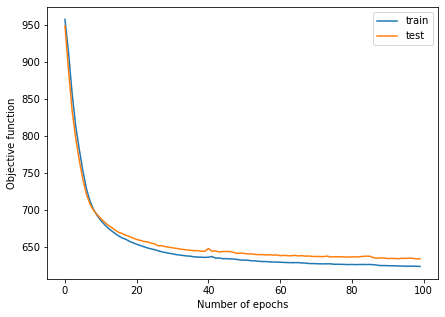

In [35]:
from matplotlib import pyplot as plt

result, test_z = fit_model(expression_train, expression_test, hpara=100, bpara=1e7)

fig = plt.figure(figsize=(7, 5)) 
plt.plot(result['epochs'], result['train_losses'], label="train")
plt.plot(result['epochs'], result['test_losses'], label="test")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Objective function")
plt.show()

In [36]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as ARI

def cluster_scores(latent_space, K, labels_true):
    labels_pred = KMeans(K, n_init=20).fit_predict(latent_space)
    return [silhouette_score(latent_space, labels_true), NMI(labels_true, labels_pred), ARI(labels_true, labels_pred)]

scores = cluster_scores(test_z, 7, label_test)
print('Clustering scores [ASW, NMI, ARI] = [%f, %f, %f].' % (scores[0], scores[1], scores[2]))

Clustering scores [ASW, NMI, ARI] = [0.208596, 0.754543, 0.733865].


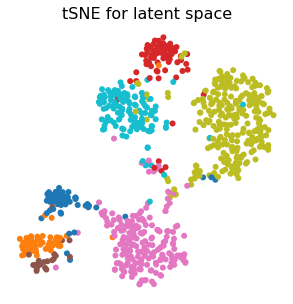

In [38]:
from sklearn.manifold import TSNE

cmap = plt.get_cmap("tab10")
z_tsne = TSNE().fit_transform(test_z)
plt.figure(figsize=(5, 5))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=label_test, cmap=cmap, edgecolors='none')
plt.axis("off")
plt.title("tSNE for latent space", fontsize=16)
plt.savefig("CORTEX_tSNE_single.png")
plt.show()

## Compare results

In [39]:
score1 = []
score2 = []
score3 = []
for i in tqdm(range(20)):
    result1, test_z1 = fit_model(expression_train, expression_test, hpara=100, bpara=0)
    result2, test_z2 = fit_model(expression_train, expression_test, hpara=100, bpara=1e7)
    _, test_z3 = fit_model(expression_train, expression_test, hpara=100, bpara=1e7, pretrain=True)
    score1.append(cluster_scores(test_z1, 7, label_test))
    score2.append(cluster_scores(test_z2, 7, label_test))
    score3.append(cluster_scores(test_z3, 7, label_test))

import pandas as pd
score1 = pd.DataFrame(score1, columns = ['ASW', 'NMI', 'ARI'])
score2 = pd.DataFrame(score2, columns = ['ASW', 'NMI', 'ARI'])
score3 = pd.DataFrame(score3, columns = ['ASW', 'NMI', 'ARI'])

100%|██████████| 20/20 [29:32<00:00, 88.65s/it]


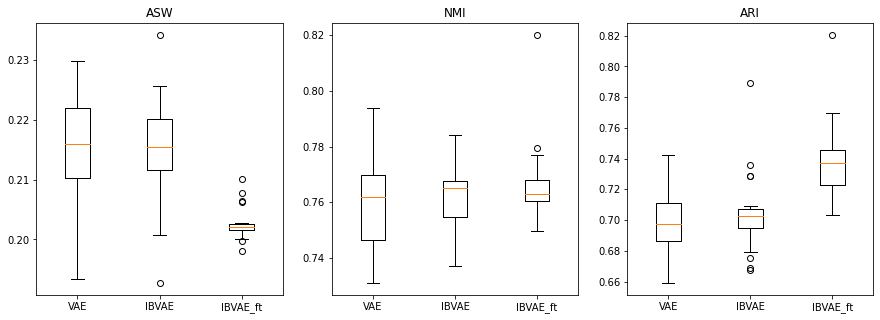

In [43]:
# boxplot
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,5))
ax1.boxplot([score1['ASW'], score2['ASW'], score3['ASW']], labels=['VAE','IBVAE','IBVAE_ft'])
ax1.set_title('ASW')
ax2.boxplot([score1['NMI'], score2['NMI'], score3['NMI']], labels=['VAE','IBVAE','IBVAE_ft'])
ax2.set_title('NMI')
ax3.boxplot([score1['ARI'], score2['ARI'], score3['ARI']], labels=['VAE','IBVAE','IBVAE_ft'])
ax3.set_title('ARI')
plt.savefig("CORTEX_boxplot.png")
plt.show()

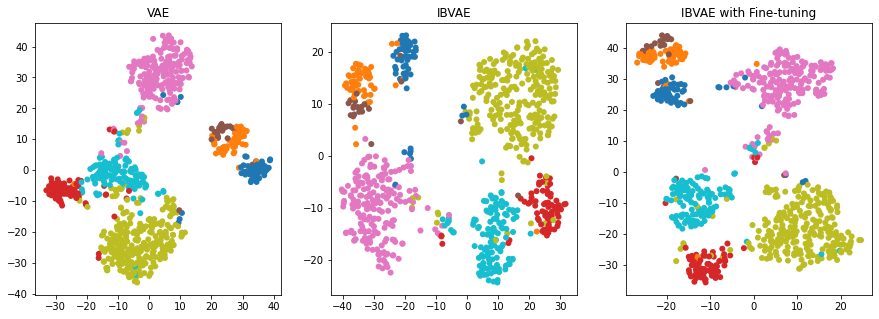

In [45]:
# tsne
cmap = plt.get_cmap("tab10")
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,5))
z_tsne1 = TSNE().fit_transform(test_z1)
z_tsne2 = TSNE().fit_transform(test_z2)
z_tsne3 = TSNE().fit_transform(test_z3)
ax1.scatter(z_tsne1[:, 0], z_tsne1[:, 1], c=label_test, cmap=cmap, edgecolors='none')
ax1.set_title('VAE')
ax2.scatter(z_tsne2[:, 0], z_tsne2[:, 1], c=label_test, cmap=cmap, edgecolors='none')
ax2.set_title('IBVAE')
ax3.scatter(z_tsne3[:, 0], z_tsne3[:, 1], c=label_test, cmap=cmap, edgecolors='none')
ax3.set_title('IBVAE with Fine-tuning')
plt.savefig("CORTEX_tSNE_compared.png")
plt.show()